In [30]:
%matplotlib inline 

import requests
from bs4 import BeautifulSoup
from bs4 import NavigableString
import pandas as pd
import StringIO
import urllib
from datetime import date, datetime, timedelta
import itertools
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy.stats.stats import pearsonr, describe
import math
import sys
from sentiment import Classifier
import pytz
import ggplot

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

import pytz
from dateutil import parser
from scipy import stats


plt.style.use('ggplot')

In [31]:
classifier = Classifier()

Tweet 1000 of 4491

Tweet 2000 of 4491

Tweet 3000 of 4491

Tweet 4000 of 4491



In [47]:
# Simple lambda function
def split(x, num):
    return int(x.split('-')[num])

# Write a function that scrapes the team trend graph for each game
def ncaatrendgraph(gameid):

    # Scrape the reference team page
    url = 'http://espn.go.com/mens-college-basketball/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"})

    away = str(teams[0].find('span', {'class', 'long-name'}).contents[0]).split(';')[0]
    home = str(teams[1].find('span', {'class', 'long-name'}).contents[0]).split(';')[0]

    # # Run through the table and get all the relevant events from that quarter
    qes = []
    tps = len(soup.find_all('table'))-1
    for num in range(1,tps):
        for item in soup.find_all('table')[num].find_all('tr')[1:]:
            event = []
            for td in item.find_all('td'):
                if len(td.contents) > 0:
                    if 'img' in str(td.contents[0]):
                        event.append(str(td.contents[0]['src']).split('/')[-1].split('.')[0].upper())
                    else:
                        if ':' in str(td.contents[0]):
                            if num > 2:
                                minutes = 4-int(td.contents[0].split(':')[0]) + 40 + ((num-3)*5)
                            else:
                                minutes = 19-int(td.contents[0].split(':')[0]) +((num-1)*20)
                            seconds = 60-int(td.contents[0].split(':')[1])

                            # Make an adjustment for exact minute calculations
                            if seconds == 60:
                                minutes = minutes + 1
                                seconds = 0

                            event.append(minutes)
                            event.append(seconds)
                        else:
                            event.append(str(td.contents[0]))
            qes.append(event)

    # Make this data into a Dataframe
    bsd = pd.DataFrame(qes, columns = ['Minutes', 'Seconds', 'Team', 'Event', 'Score'])
    bsd[away] = bsd['Score'].apply(lambda x: split(x, 0))
    bsd[home] = bsd['Score'].apply(lambda x: split(x, 1))
    bsd = bsd.drop('Score', 1)

    # # Write a quick function converting the minutes and seconds to a percentage
    if (tps) == 3:
        numminutes = 40
    else:
        numminutes = 40 + 5*(tps-3)
    lengame = numminutes*60.0
    bsd['PercDone'] = [float(100*round((mins*60+sec)/lengame,4)) for (mins, sec) in zip(bsd['Minutes'], bsd['Seconds'])]
    return bsd

In [33]:
g = ncaatrendgraph(400873156)
g1 = ncaatrendgraph(400873157)

In [48]:
# Write a function that processes the events that happen during this period
"""
Gamedata: The dataframe containing all the data above
Start: The time at which you'd like to start looking (%H:%M, ex. 7:20 (EST))
Finish: The time at which you'd like to stop looking (see above)
"""
def gamevents(gamedata, start, finish, begin, end):
    start_conv = datetime.strptime(start, '%H:%M')
    finish_conv = datetime.strptime(finish, '%H:%M')
        
    # Make quick sanity checks
    if start_conv < begin:
        start_conv = begin
    if finish_conv > end:
        finish_conv = end
    # Check where each event is in relation to halftime
    sloc, endloc = 0, 0
    lenhalf = 20*60
    htbegin = begin + timedelta(0, (end-begin).seconds/2 - lenhalf/2)
    htend = begin + timedelta(0,(end-begin).seconds/2 + lenhalf/2)
    if start_conv > htend:
        sloc = 1
    if finish_conv > htend:
        endloc = 1
        
    # Assume for now that both are on the same side of halftime
    if endloc == 0:
        ttb1, ttb2 = (start_conv - begin).seconds, (finish_conv - begin).seconds
        perc1, perc2 = round(100*(1.0*ttb1)/(2*(htbegin-begin).seconds),2), round(100*(1.0*ttb2)/(2*(htbegin-begin).seconds),2)
    elif endloc == 1:
        ttb1, ttb2 = (start_conv - htend).seconds, (finish_conv - htend).seconds
        perc1, perc2 = round(100*(1.0*ttb1)/(end-htend).seconds,2)+50, round(100*(1.0*ttb2)/(end-htend).seconds,2)+50
    
    # Grab the data from the gamedata
    return gamedata[(gamedata['PercDone'] > perc1) & (gamedata['PercDone'] < perc2)]

In [49]:
"""
Large function that will return to you the relevant game events and then a list of tweets (with their times) 
from the time period that you specify. Currently works by submitting actual times.

Inputs:
gp1: The first game participant
gp2: The second game participant
tp1: Beginning of time period (%H:%M, ex. 7:20), measured by EST
tp2: End of time period

Outputs:
dt1: Dataframe containing all the game events from that period 
dt2: Dataframe containing the tweets from that period
"""

def databytime(gp1, gp2, tp1, tp2):
    
    # Get the important metadata and define a useful constant
    gmdat = pd.read_csv("GameMetadata.csv")    
    metadat = gmdat[((gmdat['Team1'] == gp1) | (gmdat['Team1'] == gp2)) & ((gmdat['Team2'] == gp1) | (gmdat['Team2'] == gp2))]
    eid = metadat['espn_id'].iloc[0]
    begin, end = datetime.strptime(metadat['Start'].iloc[0], '%H:%M'), datetime.strptime(metadat['End'].iloc[0], '%H:%M')
    lenhalf = 20*60
    
    # Grab the game data for the time period
    gdata = ncaatrendgraph(eid)
    dt1 = gamevents(gdata, tp1, tp2, begin, end)
    
    # Grab the relevant data from the twitter file
    fname = '../separated/' + metadat['Filename'].iloc[0]
    tweets =  pd.read_csv(fname)
    tweets['time_chg'] = tweets['time'].apply(lambda x: x.split(' ')[3])
    
    indices = []
    for num in range(0, len(tweets['time_chg'])):
        tweetstamp = datetime.strptime(tweets['time_chg'].iloc[num], "%H:%M:%S") - timedelta(hours=4)
        if (tweetstamp > begin) and (tweetstamp < end):
            if (tweetstamp > datetime.strptime(tp1, '%H:%M')) and (tweetstamp < datetime.strptime(tp2, '%H:%M')):
                indices.append(num)
    dt2 = tweets[tweets.index.isin(indices)]
    
    return dt1, dt2

In [50]:
def getgamemeta(gp1, gp2):
    gmdat = pd.read_csv("GameMetadata.csv")
    metadat = gmdat[((gmdat['Team1'] == gp1) | (gmdat['Team1'] == gp2)) & ((gmdat['Team2'] == gp1) | (gmdat['Team2'] == gp2))]
    eid = metadat['espn_id'].iloc[0]
    begin, end = datetime.strptime(metadat['Start'].iloc[0], '%H:%M'), datetime.strptime(metadat['End'].iloc[0], '%H:%M')
    lenhalf = 20*60
    htbegin = begin + timedelta(0, (end-begin).seconds/2 - lenhalf/2)
    htend = begin + timedelta(0,(end-begin).seconds/2 + lenhalf/2)
    
    return {'meta':metadat,
            'start': begin,
            'end': end,
            'htstart':htbegin, 
            'htend': htend} 


In [51]:
"""
Large function that will return to you the relevant game events and then a list of tweets (with their times) 
from the time period that you specify. Currently works by submitting actual times.

Inputs:
gp1: The first game participant
gp2: The second game participant
gtp1: Beginning of game time period (20:00 -- Halftime, 35:00 -- After halftime)
gtp2: End of game time period

Outputs:
dt1: Dataframe containing all the game events from that period 
dt2: Dataframe containing the tweets from that period
"""
def databygametime(gp1, gp2, gtp1, gtp2):
    
    # Get the important metadata and define a useful constant
    gmdat = pd.read_csv("GameMetadata.csv")
    metadat = gmdat[((gmdat['Team1'] == gp1) | (gmdat['Team1'] == gp2)) & ((gmdat['Team2'] == gp1) | (gmdat['Team2'] == gp2))]
    eid = metadat['espn_id'].iloc[0]
    begin, end = datetime.strptime(metadat['Start'].iloc[0], '%H:%M'), datetime.strptime(metadat['End'].iloc[0], '%H:%M')
    lenhalf = 20*60
    htbegin = begin + timedelta(0, (end-begin).seconds/2 - lenhalf/2)
    htend = begin + timedelta(0,(end-begin).seconds/2 + lenhalf/2)
    
    # Grab the initial data by mapping gametimes to parts of the game
    fullgamedat = ncaatrendgraph(eid)
   
    bmin, bsec = gtp1.split(":")
    emin, esec = gtp2.split(":")
    btot = int(bmin)*60 + int(bsec)
    etot = int(emin)*60 + int(bsec)
    maxmin = np.max(fullgamedat['Minutes'])*60
    bperc, eperc = (100.0*btot)/maxmin, (100.0*etot)/maxmin
    dt1 = fullgamedat[(fullgamedat['PercDone'] >= bperc) & (fullgamedat['PercDone'] <= eperc)]
    
    # Use the percentages of the game to map gametimes to actual times
    acttimes = []
    for item in [bperc, eperc]:
        hperc = (item*2)/100
        if item <= 50.0:
            secdelt = round((htbegin-begin).seconds*hperc,0)
            acttimes.append(secdelt)
        elif item > 50.0:
            secdelt = round((end-htend).seconds*(hperc-1.0) + (htend-begin).seconds,0)
            acttimes.append(secdelt)
    
    # Convert the time to usable timedelt objects
    tp1, tp2 = begin + timedelta(0,seconds = acttimes[0]), begin + timedelta(0,seconds = acttimes[1])
    tp1, tp2 = str(tp1).split(" ")[1], str(tp2).split(" ")[1]
    
    # Get the relevant Tweets over that time period using identical code to before
    fname = '../separated/' + metadat['Filename'].iloc[0]
    tweets =  pd.read_csv(fname)
    tweets['time_chg'] = tweets['time'].apply(lambda x: x.split(' ')[3])
    
    indices = []
    for num in range(0, len(tweets['time_chg'])):
        tweetstamp = datetime.strptime(tweets['time_chg'].iloc[num], "%H:%M:%S")  - timedelta(hours=4)
        if (tweetstamp > begin) and (tweetstamp < end):
            if (tweetstamp > datetime.strptime(tp1, '%H:%M:%S')) and (tweetstamp < datetime.strptime(tp2, '%H:%M:%S')):
                indices.append(num)
    dt2 = tweets[tweets.index.isin(indices)]
    return dt1, dt2

In [57]:
samp1, samp2 = databygametime('Virginia', 'Syracuse', '0:00', '40:00')

In [10]:
samp3, samp4 = databytime('Virginia', 'Syracuse', '18:10', '18:20')

In [62]:
def classlam(t):
    cla = classifier.classify(t)
    if cla== 'neutral' or cla == 'irrelevant':
        return 0
    elif cla == 'positive':
        return 1
    else:
        return -1

In [71]:
samp2['classification'] = samp2['text'].map(classlam)
eastern = pytz.timezone('US/Eastern')
samp2.index = samp2['time'].map(lambda x : parser.parse(x).astimezone(eastern))

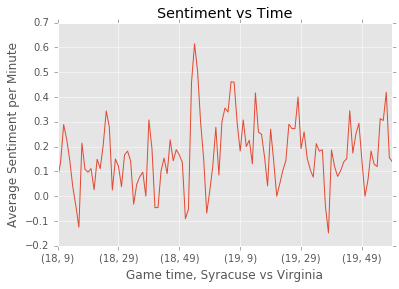

In [78]:
samp2['classification'].groupby([samp2.index.hour, samp2.index.minute]).mean().plot()
plt.title('Sentiment vs Time')
plt.xlabel('Game time, Syracuse vs Virginia')
plt.ylabel('Average Sentiment per Minute')
plt.savefig('syracusevasent.pdf')

In [12]:
### Relevance Classification

In [38]:
# Write a quick function that will grab the relevant roster items, given a team id
def grabroster(teampage):
    url = "http://" + teampage.split('team')[0] + 'team/stats' + teampage.split('team')[1]
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    names = []
    for tr in soup.find_all('table')[0].find_all('tr')[2:9]:
        for item in tr.find_all('td')[0:1]:
            names.append(str(item.contents[0].contents[0]).split(' ')[1])
    return names
    
# Write a function that will return two lists, each of which contains the last names of the top six players (as measured
# by playing time), the name of the associated coach for the team, and the 
def relvtags(gameid):
    gameid = 400873651
    url = 'http://espn.go.com/mens-college-basketball/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"}) 

    # Find the links to the right pages
    teamlinks = [str("espn.go.com" + teams[0].find_all('a')[0]['href']), 
                 str("espn.go.com" + teams[1].find_all('a')[0]['href'])]

    # Grab the correct roster for the team
    team1, team2 = grabroster(teamlinks[0]), grabroster(teamlinks[1])
    coach1, coach2 = coachdict[int(teamlinks[0].split('/')[-1])], coachdict[int(teamlinks[1].split('/')[-1])]
    team1.append(coach1.split(' ')[1])
    team2.append(coach2.split(' ')[1])
    print team1, team2

In [39]:
# Create the relevant dictionaries for the stuff coming after
coachurl = "http://espn.go.com/mens-college-basketball/story/_/id/14967272/ranking-ncaa-tournament-coaches-players-1-68"
coachhtml = urllib.urlopen(coachurl)
coachsoup = BeautifulSoup(coachhtml, "html.parser")

# Create a useful dictionary for the ids and the coach
coachdict = {}
for item in coachsoup.find_all('strong'):
    name = str(item.contents[0].split('. ')[1][:-2])
    
    # Get the associated teamid, throwing an exception for Southern (only non-linked team in the database)
    if ',' not in name:
        gid = int(item.find_all('a')[0]['href'].split('id/')[1].split('/')[0])
    else:
        gid = 2582
        name = name.split(',')[0]
    coachdict[gid] = name

# Define a dict with tags for each team
tagdict = {12: ['#Wildcats', '#Arizona', '#GoCats', '#BearDown', '#AZWildcats', '#watchus', '#APlayersProgram'],
           25: ['#Cal', '#LetsDance', '#GoldenBears', '#GoBears', '#CalFamily'],
           38: ['#Buffaloes', '#Colorado', '#GoBuffs'],
           41: ['#Huskies', '#UConn', '#Connecticut', '#bleedblue', '#GoHuskies', '#UConnbasketball', '#UConnnation'],
           43: ['#Bulldogs', '#Yale', '#OneIvy', '#YaleBasketball', '#GoYale'],
           62: ['#RainbowWarriors', '#Hawaii', '#HawaiiMBB', '#RoadWarriors', '#GoBows'],
           66: ['#Cyclones', '#IowaSt', '#IowaState', '#cyclONEnation'],
           84: ['#Hoosiers', '#IU', '#ForIndiana', '#iubb'],
           87: ['#NotreDame', '#NotDoneYet', '#FightingIrish'],
           96: ['#Kentucky', '#Wildcats', '#Cats', '#BigBlueNation'],
           107: ['#HolyCross', '#Crusaders', '#RiseTogether'],
           120: ['#WeWill', '#Maryland', '#Terrapins'],
           127: ['#Spartans', '#GoGreen', '#GoWhite', '#MSU', '#MichiganState'],
           130: ['#Michigan', '#UMich', '#Wolverines', '#Squad100', '#GoBlue'],
           150: ['#Duke', '#BlueDevils', '#GoDuke'],
           153: ['#UNC', '#TarHeels', '#HeelsLockIn', '#UNCBBall'],
           183: ['#Syracuse', '#OrangeCrush', '#CuseMode', '#StLouis'],
           201: ['#Oklahoma', '#OU', '#Sooners', '#BuddyBuckets'],
           204: ['#Beavers', '#OregonState', '#oregonstatebasketball', '#BeaverNation', '#GoBeavs'],
           218: ['#Temple', '#Owls', '#BeatIowa', '#TUMBB'],
           221: ['#Pittsburgh', '#Panthers', '#H2P'],
           222: ['#Villanova', '#Nova', '#NovaMBB', '#NovaNation', '#LetsMarchNova'],
           239: ['#Bears', '#Baylor', '#GoBears'],
           245: ['#TexasA&M', '#Aggies', '#Gigem', '#TAMU', '#12thMan', '#AggieHoops'],
           251: ['#UT', '#Longhorns', '#HookEm', '#Horns'],
           254: ['#Utah', '#Utes', '#goutes', '#Playformore', '#BeatGonzaga'],
           258: ['#Virginia', '#Cavaliers', '#Bulldogs', '#UVA', '#GoHoos'],
           275: ['#Badgers', '#Wisconsin', '#MakeEmBelieve', '#Fieldof64', '#WisconsinBasketball'],
           277: ['#WestVirginia', '#WVU', '#HailWV', '#PressVirginia', '#Mountaineers'],
           2031: ['#LittleRocksTeam'],
           2046: ['#AustinPeay', '#LetsGoPeay', '#16over1'],
           2084: ['#Bison', '#Buffalo', '#UBBulls', '#UBDancing', '#HornsUp'],
           2086: ['#Butler', '#Bulldogs', '#GoDawgs'],
           2132: ['#Cincinnati', '#Cincy', '#BearCats', '#Dancin6'],
           2168: ['#Dayton', '#Flyers', '#TrueTeam', '#GoFlyers'],
           2250: ['#Zags', '#Gonzaga', '#GoZags', '#UnitedWeZag', '#zagup'],
           2294: ['#Hawkeyes', '#Iowa'],
           2305: ['#Jayhawks', '#kubball', '#Kansas', '#RockChalk'],
           2390: ['#Hurricanes', '#Miami', '#BeatBuffalo', '#GoCanes'],
           2393: ['#MiddleTennesseeState', '#MTSU', '#BlueRaiders', '#DancingRaiders'],
           2427: ['#OurTownOurTeam', '#Bulldogs', '#Cinderella', '#UNCAsheville', '#Asheville'],
           2460: ['#NorthernIowa', '#Panthers', '#PantherNation', '#UNI', '#UNIFight'],
           2483: ['#Oregon', '#Ducks', '#GoDucks'],
           2507: ['#Friars', '#PCBB', '#gofriars', '#pcbb', '#dunnions'],
           2550: ['#SetonHall', '#HALLin', '#shbb', '#SHUnited'],
           2571: ['#SDSU', '#Jackrabbits', '#MarchTogether'],
           2603: ['#StJoes', '#Hawks', '#StJosephs', '#THWND'],
           2617: ['#Lumberjacks', '#SFA', '#AxeEm'],
           2670: ['#Rams', '#LetsGoVCU', '#VCU'],
           2692: ['#Wildcats', '#WeberState', '#WeAreWeber', '#BigSkyMBB'],
           2724: ['#Wildcats', '#Shockers', '#Shocktheworld', '#WichitaSt'],
           2739: ['#RP40', '#HLMBB', '#ContinueTheRise', '#GreenBay'],
           2752: ['#Xavier', '#Musketeers', '#LetsGoX', '#LetsMarch'],
           2934: ['#CSUBelieve', '#AllRunners', '#CSUB']}

In [40]:
# Write a quick function that will grab the relevant roster items, given a team id
def grabroster(teampage):
    url = "http://" + teampage.split('team')[0] + 'team/stats' + teampage.split('team')[1]
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    names = []
    for tr in soup.find_all('table')[0].find_all('tr')[2:9]:
        for item in tr.find_all('td')[0:1]:
            names.append(str(item.contents[0].contents[0]).split(' ')[1])
    return names
    
# Write a function that will return two lists, each of which contains the last names of the top six players (as measured
# by playing time), the name of the associated coach for the team, and the 
def relvtags(gameid):
    url = 'http://espn.go.com/mens-college-basketball/playbyplay?gameId=' + str(gameid)
    html = urllib.urlopen(url)
    soup = BeautifulSoup(html, "html.parser") 

    # Identify which team is which from the basic page
    teams = soup.find_all('div', {'class', "team-container"}) 

    # Find the links to the right pages
    teamlinks = [str("espn.go.com" + teams[0].find_all('a')[0]['href']), 
                 str("espn.go.com" + teams[1].find_all('a')[0]['href'])]

    # Grab the correct roster for the team
    x = []
    for item in teamlinks:
        team = grabroster(item)
        gid = int(item.split('/')[-1])
        team.append(coachdict[gid].split(' ')[1])
        for tag in tagdict[gid]:
            team.append(tag)
            team.append(tag.split('#')[1])
        x.append(team)
    return x

In [41]:
# Go through and classify whether a text is in the tweet
def textcheck(tweet, array):
    relvs = []
    for tagset in array:
        counter = 0
        for word in tagset:
            if word in tweet:
                counter += 1
        # Check if anything showed up
        if counter > 0:
            relvs.append(1)
            relvs.append(counter)
        else:
            relvs.append(0)
        relvs.append(0)
    return relvs

In [42]:
"""
Given relevant keywords for the 2 teams, add what keywords appear for each.
"""
def addrelevance(df, wordset):
    def textchecksingle(tweet, wset):
        twdict = {w:True for w in tweet.split()}
        return [w for w in wset if w in twdict]
    
    df['Team1RelWords'] = df['text'].map(lambda t : textchecksingle(t, tags[0]))
    df['Team2RelWords'] = df['text'].map(lambda t : textchecksingle(t,tags[1]))
    
    t1len = len(tags[0])
    t2len = len(tags[1])
    
    df['Team1RelScore'] = df['Team1RelWords'].map(lambda t : float(len(t))/t1len)
    df['Team2RelScore'] = df['Team2RelWords'].map(lambda t : float(len(t))/t2len)
    
    return df

In [18]:
tags = relvtags(400873156)

In [19]:
samp2 = addrelevance(samp2,tags)

In [20]:
eastern = pytz.timezone('US/Eastern')
samp2.index = samp2['time'].map(lambda x : parser.parse(x).astimezone(eastern))

In [21]:
samp2['Team1RelScore'] = samp2['Team1RelScore'] * 10

In [22]:
def classlam(t):
    cla = classifier.classify(t)
    if cla== 'neutral' or cla == 'irrelevant':
        return 0
    elif cla == 'positive':
        return 1
    else:
        return -1

In [55]:
samp2['Sentiments'] = samp2['text'].map(classlam)

In [56]:
samp2

,text,time,time_chg,classification,Team1RelWords,Team2RelWords,Team1RelScore,Team2RelScore,Sentiments
time,,,,,,,,,


In [24]:
countts = samp2['text'].groupby([samp2.index.hour, samp2.index.minute]).count().plot()

AttributeError: 'Index' object has no attribute 'hour'

In [52]:
def tweeteventplotandregression(team1, team2):
    gamemeta = getgamemeta(team1, team2)
    events, tweets = databygametime(team1, team2, '0:00', '40:00')    
    eastern = pytz.timezone('US/Eastern')
    tweets.index = tweets['time'].map(lambda x : parser.parse(x).astimezone(eastern))
    
    events['Delta'] = events.apply(lambda r : timedelta(minutes=r['Minutes']) +
                                            timedelta(seconds = r['Seconds']), axis=1)
    events['FirstHalf'] = events.apply(lambda r : r['Delta'] < timedelta(minutes=20), axis = 1)
    
    def addclock(row):
        if row['FirstHalf']:
            return row['Delta'] + gamemeta['start']
        else:
            return row['Delta'] + gamemeta['htend']
    
    events['WallClockTime'] = events.apply(addclock, axis=1)
    events.index = events['WallClockTime']
    
#     evtotal = sum(events['Event'].groupby([events.index.hour, events.index.minute]).count())
#     twtotal = sum(tweets['text'].groupby([tweets.index.hour,tweets.index.minute]).count())
       
    # group by hour and minute
    eventts = events['Event'].groupby([events.index.hour, events.index.minute]).count() # /evtotal
    tweetts = tweets['text'].groupby([tweets.index.hour,tweets.index.minute]).count() # /twtotal
    
    # convert groupings to dataframe
    eventtsdf = eventts.to_frame()
    tweettsdf = tweetts.to_frame()
    
    jointdf = tweettsdf.join(eventtsdf).fillna(0)
    
    # make plots
    jointdf['text'].plot()
    jointdf['Event'].plot()
    
    # run a basic regression
    
    reg = slope, intercept, r_value, p_value, slope_std_error = stats.linregress(jointdf['Event'], jointdf['text'])
    
    preds = intercept + slope*jointdf['Event'].values
    plt.plot(preds)
    plt.title('Tweet and Event Volumes')
    plt.xlabel("Minute in Game")
    plt.ylabel('Volume (per minute)')
    plt.legend(['Tweets', 'Game Events'])
    plt.savefig(team1+team2+'tsvolume.pdf')
    
    plt.figure()
    plt.scatter(jointdf['Event'], jointdf['text'])
    plt.plot(jointdf['Event'], preds)
    
    return (reg)
    

In [53]:
def marginplot(team1, team2):
    gamemeta = getgamemeta(team1, team2)
    events, tweets = databygametime(team1, team2, '0:00', '40:00')    
    eastern = pytz.timezone('US/Eastern')
    tweets.index = tweets['time'].map(lambda x : parser.parse(x))#.astimezone(eastern))
    
    events['Delta'] = events.apply(lambda r : timedelta(minutes=r['Minutes']) +
                                                timedelta(seconds = r['Seconds']), axis=1)
    events['FirstHalf'] = events.apply(lambda r : r['Delta'] < timedelta(minutes=20), axis = 1)

    def addclock(row):
        if row['FirstHalf']:
            return row['Delta'] + gamemeta['start']
        else:
            return row['Delta'] + gamemeta['htend']

    events['WallClockTime'] = events.apply(addclock, axis=1)
    events.index = events['WallClockTime']
    
    events['Margin'] = events[team1] - events[team2]
    events['MarginChange'] = abs(events['Margin'] - events['Margin'].shift())
    
    marginchangets = events['MarginChange'].groupby([events.index.hour, events.index.minute]).mean()
    tweetts = tweets['text'].groupby([tweets.index.hour,tweets.index.minute]).count() # /twtotal

    eventtsdf = marginchangets.to_frame()
    tweettsdf = tweetts.to_frame()
    
    jointdf = tweettsdf.join(eventtsdf).fillna(0)
    
    # make plots
    normtext = (jointdf['text'] - jointdf['text'].mean())/jointdf['text'].std()
    normmargin = (jointdf['MarginChange'] - jointdf['MarginChange'].mean())/jointdf['MarginChange'].std()
    (normtext).plot()
    (normmargin).plot()
    
    # run a basic regression
    
    reg = slope, intercept, r_value, p_value, slope_std_error = stats.linregress(normtext[jointdf['MarginChange'] != 0], normmargin[jointdf['MarginChange'] != 0],)
    
    preds = intercept + slope*jointdf['MarginChange'].values
    
    plt.title('Normalized Volume and Game Margin')
    plt.xlabel("Minute in Game, {0} vs {1}".format(team1, team2))
    plt.ylabel('z-score')
    plt.legend(['Tweets', 'Change in Margin'])
    plt.savefig(team1.replace(' ', '').lower()+team2.replace(' ', '').lower()+'marginzscoreplot.pdf')
    
    return (reg)
    

LinregressResult(slope=-0.24941221092968002, intercept=1.0792088613603825, rvalue=-0.18783880976959874, pvalue=0.27261559552526127, stderr=0.22366230567846931)

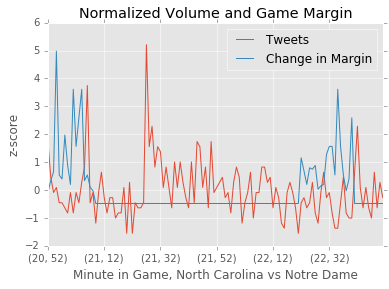

In [45]:
marginplot('North Carolina', 'Notre Dame')

LinregressResult(slope=1.9076756043199186, intercept=44.721180612020397, rvalue=0.16221635848986385, pvalue=0.088944028887695897, stderr=1.1114912778817234)

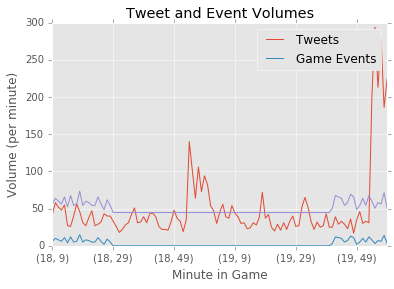

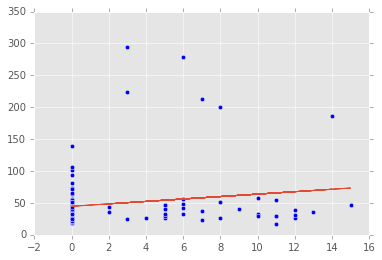

In [54]:
tweeteventplotandregression('Syracuse', 'Virginia')

In [ ]:
reg = tweeteventplotandregression('North Carolina','Notre Dame')

In [ ]:
reg

In [ ]:
gamemeta = getgamemeta('Syracuse', 'Virginia')

In [ ]:
gamemeta

In [ ]:
gamemeta['start']

In [ ]:
print gamemeta['htstart']
print gamemeta['htend']

In [ ]:
samp1['Delta'] = samp1.apply(lambda r : timedelta(minutes=r['Minutes']) + timedelta(seconds = r['Seconds']), axis=1)

In [ ]:
samp1['FirstHalf'] = samp1.apply(lambda r : r['Delta'] < timedelta(minutes=20), axis = 1)

In [ ]:
def addclock(row):
    if row['FirstHalf']:
        return row['Delta'] + gamemeta['start']
    else:
        return row['Delta'] + gamemeta['htend']

In [ ]:
samp1['WallClockTime'] = samp1.apply(addclock, axis=1)

In [ ]:
samp1.index = samp1['WallClockTime']

In [ ]:
evtotal = sum(samp1['Event'].groupby([samp1.index.hour, samp1.index.minute]).count())
twtotal = sum(samp2['text'].groupby([samp2.index.hour,samp2.index.minute]).count())
eventts = samp1['Event'].groupby([samp1.index.hour, samp1.index.minute]).count()/evtotal
tweetts = samp2['text'].groupby([samp2.index.hour,samp2.index.minute]).count()/twtotal

In [ ]:
eventtsdf = eventts.to_frame()
tweettsdf = tweetts.to_frame()

In [ ]:
jointdf = tweettsdf.join(eventtsdf).fillna(0)

In [ ]:
stats.linregress(jointdf['Event'], jointdf['text'])

In [ ]:
jointdf['text'].plot()
jointdf['Event'].plot()
plt.savefig('tweetandevent.pdf')